#DESAFIO 5

**Mejoras implementadas en el modelo**

1.   Ajuste del parámetro Output_shape: Se modificó el valor de output_shape de 3 a 5 para reflejar el número de clases en la tarea de clasificación multiclase, permitiendo que el modelo se adapte a un mayor número  de categorías.

  Las cuales son:
  
  Clase 0: Muy negativo (puntuación = 1),
  Clase 1: Negativo (puntuación = 2), Clase 2: Neutro (puntuación = 3),
  Clase 3: Positivo (puntuación = 4), Clase 4: Muy positivo (puntuación = 5)
  
2.   Capas Densas Adicionales : Se añadieron dos capas densas con 128 y 64 neuronas respectivamente, para mejorar la capacidad del modelo de aprender representaciones más abstractas y complejas de los datos.
3.   Regularización con Dropout : Se incorporó una tasa de Dropout del 30% despues de cada capa densa, para evitar el sobreajuste y mejorar la capacidad del modelo para generalizar en datos no vistos.
4.   Capa de salida : La capa de salida con activación softmax fue ajustada para manejar 5 clases, lo que asegura que el modelo pueda producir probabilidades para cada una de ellas.
5. Compilación del modelo : El modelo fue compilado con las métricas accuracy y F1_score, proporcionando una evaluación mas equilibrada del rendimiento del modelo en la clasificación multiclase.



In [ ]:
!pip install transformers --quiet

In [ ]:
import seaborn as sns
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from transformers import TFBertModel
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

### Definiendo modelo

In [ ]:
# Cargamos el modelo pre-entrenado (Versión bert-base-uncased)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Parámetros del modelo

In [ ]:
# max_length : Longitud máxima de las secuencias de entrada (Tokens)
max_length = 140
# Clasificación en 5 categorias
output_shape = 5

In [ ]:
bert_model.bert.trainable = False
# Definimos una capa de entrada que representa los IDs de los tokens
input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
# Otra capa de entrada - nos indica que tokens deben ser atendidos
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

# Pasamos los Ids de los tokens y la mascara de atención
outputs = bert_model(input_ids=tensorflow.convert_to_tensor(input_ids),
                     attention_mask=tensorflow.convert_to_tensor(attention_mask))

# Tomamos la salida de la capa de pooling del modelo BERT
pooled_output = outputs.pooler_output

# Añadimos mas capas densas despues del modelo BERT
x = tensorflow.keras.layers.Dense(128, activation='relu')(pooled_output)  # Primera capa densa
x = tensorflow.keras.layers.Dropout(0.3)(x)  # Dropout después de la capa densa
x = tensorflow.keras.layers.Dense(64, activation='relu')(x)  # Segunda capa densa
x = tensorflow.keras.layers.Dropout(0.3)(x) # Añadimos una capa dropout para regularizar el modelo

# Capa de salida
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

# Definimos el modelo
model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compilamos el modelo con el optimizador Adam , función de pérdida categorical_crossentropy y las métricas accuracy y F1 Score
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf.convert_to_tensor (TFOp  (None, 140)                  0         ['input_ids[0][0]']           
 Lambda)                                                                                          
                                                                                              

In [ ]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    # Creamos el gráfico con seaborn
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
    sns.lineplot(x=epoch_count, y=history.history['accuracy'], label='Train Accuracy')
    sns.lineplot(x=epoch_count, y=history.history['val_accuracy'], label='Validation Accuracy')
    # Añadimos etiquetas y título
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    # Mostramos el gráfico
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [ ]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  43060      0  0:00:03  0:00:03 --:--:-- 84230
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   629k      0  0:00:11  0:00:11 --:--:-- 1957k


In [ ]:
# Armamos el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
print(df['score'].unique())

[1 2 3 4 5]


In [ ]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

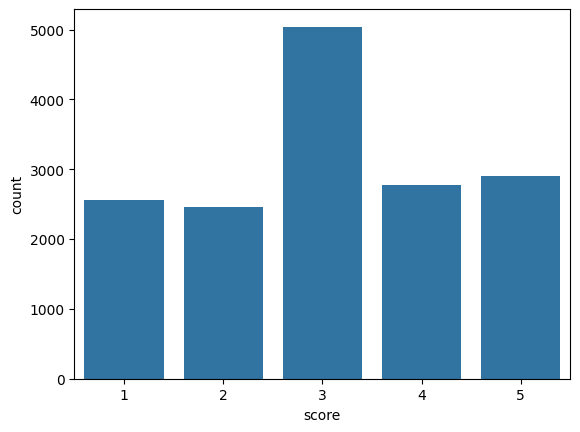

In [ ]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

## Limpieza de datos

In [ ]:
# Balancear los datos
df['sentiment'] = df.score.apply(lambda x: 0 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3 if x == 4 else 4)
class_names = ['very negative', 'negative', 'neutral', 'positive', 'very positive']

<ipython-input-15-15c40b0fa175>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


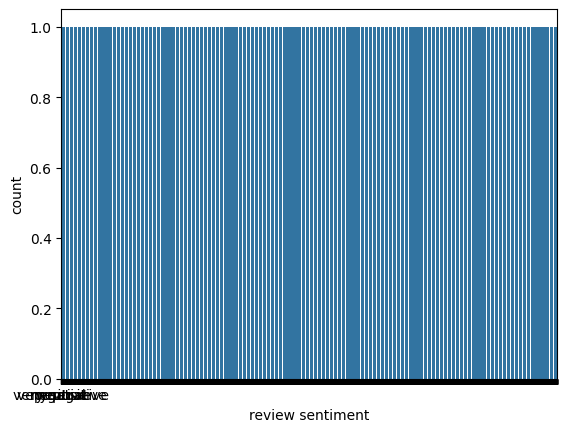

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


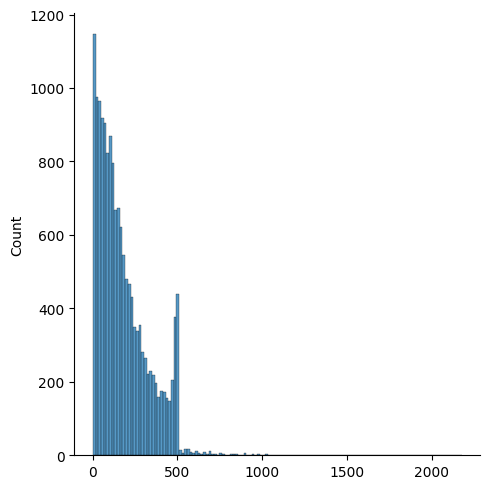

In [ ]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [ ]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


In [ ]:
# Verificamos el equilibrio de las clases
print(pd.Series(y.argmax(axis=1)).value_counts())

2    5042
4    2900
3    2776
0    2566
1    2462
Name: count, dtype: int64


## 1 - Data generator


In [ ]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

In [ ]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [ ]:
# Visualizamos las muestras en nuestros conjuntos de entrenamiento,validación y prueba
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [ ]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                   "input_ids": tf.convert_to_tensor(f.input_ids),
                   "attention_mask": tf.convert_to_tensor(f.attention_mask),
                },
                f.label,
)

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [ ]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [ ]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [ ]:
y_test = y[idx_test]

## 2 - BERT multiclass classification

In [ ]:
history1 = model.fit(train_data, epochs=30, validation_data=validation_data)

Epoch 1/30
315/315 [==============================] - 161s 460ms/step - loss: 1.5882 - accuracy: 0.2975 - f1_score: 0.1645 - val_loss: 1.5391 - val_accuracy: 0.3298 - val_f1_score: 0.1274
Epoch 2/30
315/315 [==============================] - 127s 402ms/step - loss: 1.5154 - accuracy: 0.3438 - f1_score: 0.1709 - val_loss: 1.4395 - val_accuracy: 0.3972 - val_f1_score: 0.2132
Epoch 3/30
315/315 [==============================] - 127s 402ms/step - loss: 1.4494 - accuracy: 0.3719 - f1_score: 0.2043 - val_loss: 1.3620 - val_accuracy: 0.4123 - val_f1_score: 0.2235
Epoch 4/30
315/315 [==============================] - 127s 403ms/step - loss: 1.4617 - accuracy: 0.3564 - f1_score: 0.1955 - val_loss: 1.3608 - val_accuracy: 0.3996 - val_f1_score: 0.2165
Epoch 5/30
315/315 [==============================] - 127s 402ms/step - loss: 1.4360 - accuracy: 0.3689 - f1_score: 0.2047 - val_loss: 1.3551 - val_accuracy: 0.4127 - val_f1_score: 0.2254
Epoch 6/30
315/315 [==============================] - 127s 4

Comentario:

El entrenamiento del modelo mostró mejoras adecuadas en precisión y puntaje F1 a lo largo de las 30 épocas. La precisión inicial fue del 29.75% con una pérdida de 1.5882, y al final alcanzó el 42.39% con una pérdida de 1.2677. El puntaje F1 mejoró de 0.1645 a 0.2980. En el conjunto de validación, la precisión fue de 46.39% con un puntaje F1 de 0.3238, lo que sugiere que el modelo es adecuado, aunque aún hay margen para perfeccionarlo.

In [ ]:
model.save('mi_modelo_entrenado.h5')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


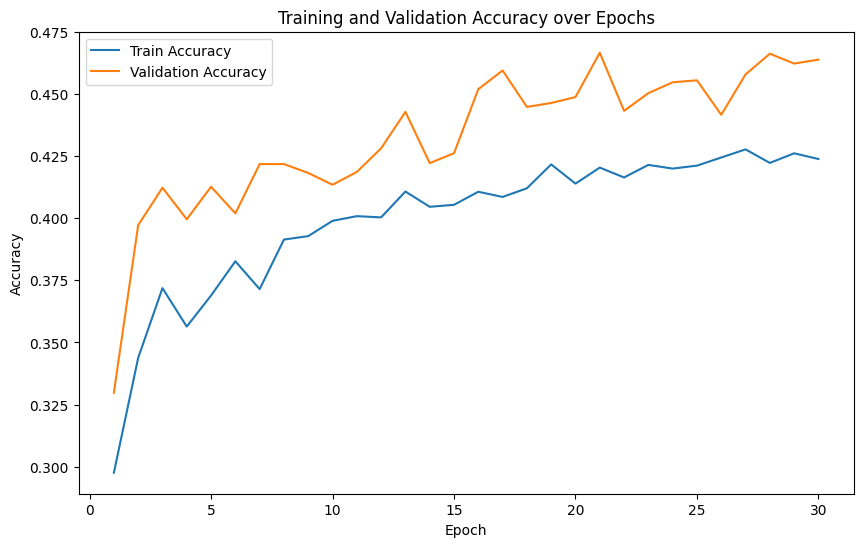

In [ ]:
plot_train_metrics(history1)

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 34s 292ms/step


array([[0.2340323 , 0.2313605 , 0.39701512, 0.10425895, 0.0333331 ],
       [0.23327497, 0.23108995, 0.39737612, 0.10471397, 0.033545  ],
       [0.09731155, 0.12937787, 0.38106304, 0.23818222, 0.15406531]],
      dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 32s 298ms/step - loss: 1.2782 - accuracy: 0.4489 - f1_score: 0.3194


0.448888897895813

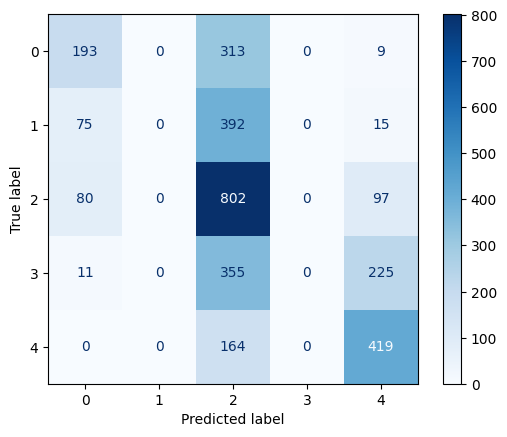

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## Ensayo

In [ ]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [ ]:
y_prob_ensayo = model.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob[0])])

1/1 [==============================] - 0s 146ms/step
Clasificación: very positive
